In [6]:
import os
import cv2
import numpy as np
import pytesseract
from PIL import Image, ImageChops, ImageEnhance
from tqdm import tqdm
from langdetect import detect
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd
from spellchecker import SpellChecker
from collections import defaultdict
from pdf2image import convert_from_path
import tempfile
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model

# Set seed for reproducibility
np.random.seed(2)

# Define the path to Tesseract
pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'


In [7]:
img_size = 128
spell = SpellChecker()

# Error Level Analysis (ELA) Conversion
def convert_to_ela_image(path, quality=90):
    try:
        original_image = Image.open(path).convert('RGB')
        resaved_path = 'resaved.jpg'
        original_image.save(resaved_path, 'JPEG', quality=quality)
        resaved_image = Image.open(resaved_path)
        ela_image = ImageChops.difference(original_image, resaved_image)
        extrema = ela_image.getextrema()
        max_diff = max([ex[1] for ex in extrema])
        if max_diff == 0:
            max_diff = 1
        scale = 255.0 / max_diff
        ela_image = ImageEnhance.Brightness(ela_image).enhance(scale)
        return ela_image
    except Exception as e:
        print(f"Error in convert_to_ela_image for {path}: {str(e)}")
        raise


In [4]:
def is_image(file_path):
    return any(file_path.lower().endswith(ext) for ext in ['.jpg', '.jpeg', '.png', '.bmp', '.gif'])


# Function to build image list from a given directory
def build_image_list(folder):
    images = []
    for entry in os.listdir(folder):
        image_path = os.path.join(folder, entry)
        if is_image(image_path):
            images.append(image_path)
    return images


def detect_language(text):
    try:
        return detect(text)
    except:
        return 'unknown'

In [8]:
custom_path_original = 'images/training/original'
custom_path_tampered = 'images/training/forged'

image_list = build_image_list(custom_path_original) + build_image_list(custom_path_tampered)


In [9]:
def check_image_quality(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    blur = cv2.Laplacian(img, cv2.CV_64F).var()
    return blur >= 100

# Extract text from image and detect the language
def extract_text_and_detect_language(image_path):
    try:
        if not check_image_quality(image_path):
            raise ValueError("Image is too blurry.")
        
        text = pytesseract.image_to_string(Image.open(image_path))
        if not text.strip():
            raise ValueError("No text found in image.")
        return text, detect(text)
    except Exception as e:
        print(f"Error processing {image_path}: {str(e)}")
        return None, 'unknown'

In [14]:
image_name = []
label = []
language = []
for image_path in tqdm(image_list):
    image_name.append(image_path)
    label.append(os.path.basename(os.path.dirname(image_path)))
    text, detected_lang = extract_text_and_detect_language(image_path)
    language.append(detected_lang if text is not None else 'unknown')

# Create a dataset DataFrame
dataset = pd.DataFrame({'image': image_name, 'class_label': label, 'language': language})
dataset.to_csv('dataset.csv', index=False)

  1%|          | 34/4818 [00:15<27:49,  2.87it/s] 

Error processing images/training/original\0000106745.jpg: No features in text.


  1%|          | 39/4818 [00:17<17:31,  4.54it/s]

Error processing images/training/original\0000116109.jpg: No text found in image.
Error processing images/training/original\0000126151.jpg: No text found in image.


  2%|▏         | 83/4818 [00:37<29:13,  2.70it/s]

Error processing images/training/original\0000261012.jpg: No text found in image.


  2%|▏         | 101/4818 [00:44<22:07,  3.55it/s]

Error processing images/training/original\0000386133.jpg: No text found in image.


  2%|▏         | 103/4818 [00:44<17:32,  4.48it/s]

Error processing images/training/original\0000400100.jpg: No text found in image.


  2%|▏         | 105/4818 [00:45<22:21,  3.51it/s]

Error processing images/training/original\0000417173.jpg: No text found in image.


  2%|▏         | 108/4818 [00:46<16:59,  4.62it/s]

Error processing images/training/original\0000426350.jpg: No text found in image.
Error processing images/training/original\0000429949.jpg: No text found in image.


  2%|▏         | 110/4818 [00:46<16:10,  4.85it/s]

Error processing images/training/original\0000437618.jpg: No text found in image.


  2%|▏         | 119/4818 [00:48<19:02,  4.11it/s]

Error processing images/training/original\0000472587.jpg: No text found in image.


  3%|▎         | 127/4818 [00:51<23:30,  3.33it/s]

Error processing images/training/original\0000565309.jpg: No text found in image.


  3%|▎         | 133/4818 [00:55<40:26,  1.93it/s]

Error processing images/training/original\0000722304.jpg: No text found in image.


  3%|▎         | 162/4818 [01:06<21:27,  3.62it/s]

Error processing images/training/original\0001152495.jpg: No text found in image.


  4%|▎         | 176/4818 [01:10<21:25,  3.61it/s]

Error processing images/training/original\0001224604.jpg: No features in text.


  4%|▍         | 183/4818 [01:13<22:58,  3.36it/s]

Error processing images/training/original\0001235477.jpg: No text found in image.
Error processing images/training/original\0001238247.jpg: No text found in image.


  6%|▌         | 280/4818 [01:52<24:55,  3.03it/s]

Error processing images/training/original\0012944949.jpg: No text found in image.
Error processing images/training/original\0012947617.jpg: No text found in image.


  6%|▌         | 296/4818 [01:58<23:06,  3.26it/s]

Error processing images/training/original\0030049534.jpg: No text found in image.


  6%|▋         | 310/4818 [02:05<31:40,  2.37it/s]

Error processing images/training/original\0060019671.jpg: No text found in image.


  7%|▋         | 320/4818 [02:08<24:14,  3.09it/s]

Error processing images/training/original\0060064025.jpg: No text found in image.


  7%|▋         | 329/4818 [02:11<27:11,  2.75it/s]

Error processing images/training/original\0060081682.jpg: No features in text.


  7%|▋         | 341/4818 [02:15<21:52,  3.41it/s]

Error processing images/training/original\0060095700.jpg: No features in text.
Error processing images/training/original\0060096268.jpg: No text found in image.


  7%|▋         | 349/4818 [02:17<19:40,  3.79it/s]

Error processing images/training/original\0060116928.jpg: No text found in image.


  8%|▊         | 364/4818 [02:22<24:48,  2.99it/s]

Error processing images/training/original\0060141655.jpg: No text found in image.


  8%|▊         | 367/4818 [02:24<25:30,  2.91it/s]

Error processing images/training/original\0060143042.jpg: No features in text.


  8%|▊         | 376/4818 [02:26<18:33,  3.99it/s]

Error processing images/training/original\0060164184.jpg: No text found in image.


  8%|▊         | 378/4818 [02:27<15:03,  4.92it/s]

Error processing images/training/original\0060182423.jpg: No text found in image.


  8%|▊         | 383/4818 [02:28<21:12,  3.48it/s]

Error processing images/training/original\0060197883.jpg: No text found in image.
Error processing images/training/original\0060198652.jpg: No text found in image.


  8%|▊         | 386/4818 [02:29<16:10,  4.57it/s]

Error processing images/training/original\0060200236.jpg: No text found in image.
Error processing images/training/original\0060200656.jpg: No text found in image.


  8%|▊         | 388/4818 [02:29<15:58,  4.62it/s]

Error processing images/training/original\0060204871.jpg: No text found in image.


  8%|▊         | 400/4818 [02:33<27:09,  2.71it/s]

Error processing images/training/original\0060267018.jpg: No text found in image.


  8%|▊         | 402/4818 [02:34<24:33,  3.00it/s]

Error processing images/training/original\0060268167.jpg: No text found in image.


  9%|▉         | 422/4818 [02:41<20:06,  3.64it/s]

Error processing images/training/original\0071000474.jpg: No text found in image.


 10%|█         | 497/4818 [03:19<27:18,  2.64it/s]  

Error processing images/training/original\03638969.jpg: No text found in image.


 11%|█         | 507/4818 [03:23<23:08,  3.11it/s]

Error processing images/training/original\03758562.jpg: No text found in image.


 11%|█▏        | 544/4818 [03:41<32:47,  2.17it/s]

Error processing images/training/original\1000330653_1000330660.jpg: No text found in image.


 11%|█▏        | 545/4818 [03:41<28:27,  2.50it/s]

Error processing images/training/original\1000331397_1000331417.jpg: No text found in image.


 11%|█▏        | 549/4818 [03:42<17:43,  4.02it/s]

Error processing images/training/original\1000407731_1000407763.jpg: No features in text.


 12%|█▏        | 562/4818 [03:46<21:59,  3.23it/s]

Error processing images/training/original\10018176_10018205.jpg: No text found in image.


 14%|█▍        | 685/4818 [05:01<19:23,  3.55it/s]  

Error processing images/training/original\10400665.jpg: No text found in image.


 15%|█▍        | 699/4818 [05:11<37:47,  1.82it/s]

Error processing images/training/original\10421388.jpg: No text found in image.


 15%|█▌        | 724/4818 [05:23<27:25,  2.49it/s]

Error processing images/training/original\11290068.jpg: No text found in image.


 15%|█▌        | 725/4818 [05:23<25:35,  2.67it/s]

Error processing images/training/original\11293116.jpg: No text found in image.


 16%|█▌        | 768/4818 [05:44<28:55,  2.33it/s]

Error processing images/training/original\2015051885.jpg: No text found in image.


 17%|█▋        | 820/4818 [06:08<24:40,  2.70it/s]

Error processing images/training/original\2022880810.jpg: No text found in image.


 17%|█▋        | 823/4818 [06:09<25:40,  2.59it/s]

Error processing images/training/original\2022915037.jpg: No text found in image.


 17%|█▋        | 840/4818 [06:16<25:21,  2.61it/s]

Error processing images/training/original\2023592247.jpg: No features in text.


 18%|█▊        | 852/4818 [06:21<17:38,  3.75it/s]

Error processing images/training/original\2024260223.jpg: No text found in image.


 18%|█▊        | 857/4818 [06:23<21:41,  3.04it/s]

Error processing images/training/original\2024273635.jpg: No text found in image.


 18%|█▊        | 862/4818 [06:25<21:07,  3.12it/s]

Error processing images/training/original\2024407513.jpg: No features in text.


 18%|█▊        | 880/4818 [06:32<24:24,  2.69it/s]

Error processing images/training/original\2024948748.jpg: No features in text.


 18%|█▊        | 885/4818 [06:34<26:23,  2.48it/s]

Error processing images/training/original\2025027963.jpg: No features in text.


 18%|█▊        | 890/4818 [06:37<32:34,  2.01it/s]

Error processing images/training/original\2025330544.jpg: No features in text.


 19%|█▉        | 904/4818 [06:44<26:03,  2.50it/s]

Error processing images/training/original\2025822605.jpg: No features in text.


 19%|█▉        | 916/4818 [06:48<27:24,  2.37it/s]

Error processing images/training/original\2026351533.jpg: No text found in image.


 19%|█▉        | 925/4818 [06:51<18:48,  3.45it/s]

Error processing images/training/original\2028368978.jpg: No features in text.


 20%|██        | 967/4818 [07:08<17:51,  3.59it/s]

Error processing images/training/original\2028989426.jpg: No features in text.


 20%|██        | 968/4818 [07:08<16:54,  3.80it/s]

Error processing images/training/original\2029019868.jpg: No features in text.


 20%|██        | 978/4818 [07:12<17:20,  3.69it/s]

Error processing images/training/original\2029164121.jpg: No features in text.


 20%|██        | 984/4818 [07:14<16:37,  3.84it/s]

Error processing images/training/original\2029249971.jpg: No text found in image.


 21%|██        | 988/4818 [07:15<16:24,  3.89it/s]

Error processing images/training/original\2030089269.jpg: No features in text.


 21%|██        | 995/4818 [07:17<16:27,  3.87it/s]

Error processing images/training/original\2030616637.jpg: No features in text.


 21%|██        | 999/4818 [07:18<13:42,  4.64it/s]

Error processing images/training/original\2030716542.jpg: No text found in image.


 21%|██        | 1003/4818 [07:18<11:41,  5.44it/s]

Error processing images/training/original\2030981001.jpg: No text found in image.
Error processing images/training/original\2030981057.jpg: No text found in image.


 22%|██▏       | 1037/4818 [07:32<13:37,  4.62it/s]

Error processing images/training/original\2040455777.jpg: No text found in image.


 22%|██▏       | 1041/4818 [07:33<11:57,  5.27it/s]

Error processing images/training/original\2040722387.jpg: Image is too blurry.


 22%|██▏       | 1062/4818 [07:42<22:24,  2.79it/s]

Error processing images/training/original\2040812082.jpg: No features in text.


 22%|██▏       | 1064/4818 [07:43<19:06,  3.27it/s]

Error processing images/training/original\2040925853-b.jpg: No features in text.


 22%|██▏       | 1079/4818 [07:50<26:20,  2.37it/s]

Error processing images/training/original\2041237000.jpg: No text found in image.


 23%|██▎       | 1089/4818 [07:53<22:51,  2.72it/s]

Error processing images/training/original\2041583596.jpg: No features in text.


 23%|██▎       | 1104/4818 [07:58<13:05,  4.73it/s]

Error processing images/training/original\2041867833.jpg: No features in text.
Error processing images/training/original\2041950459.jpg: No text found in image.


 23%|██▎       | 1108/4818 [07:59<18:28,  3.35it/s]

Error processing images/training/original\2042015214.jpg: No features in text.


 23%|██▎       | 1112/4818 [08:00<16:18,  3.79it/s]

Error processing images/training/original\2043123487.jpg: No text found in image.
Error processing images/training/original\2043214503.jpg: No features in text.


 23%|██▎       | 1121/4818 [08:03<14:03,  4.38it/s]

Error processing images/training/original\2044115217.jpg: Image is too blurry.
Error processing images/training/original\2044123682.jpg: No text found in image.


 25%|██▍       | 1192/4818 [08:35<21:30,  2.81it/s]

Error processing images/training/original\2063118582.jpg: No text found in image.


 25%|██▌       | 1223/4818 [08:48<17:50,  3.36it/s]

Error processing images/training/original\2064763047.jpg: No features in text.


 26%|██▌       | 1230/4818 [08:50<17:42,  3.38it/s]

Error processing images/training/original\2065463528_3614.jpg: No features in text.


 26%|██▋       | 1274/4818 [09:05<13:31,  4.37it/s]

Error processing images/training/original\2072916935_6953.jpg: No features in text.


 29%|██▉       | 1406/4818 [10:08<24:31,  2.32it/s]

Error processing images/training/original\500463755.jpg: No features in text.


 29%|██▉       | 1412/4818 [10:11<20:11,  2.81it/s]

Error processing images/training/original\500596653+-6655.jpg: No text found in image.


 29%|██▉       | 1416/4818 [10:12<20:37,  2.75it/s]

Error processing images/training/original\500713414_500713415.jpg: No text found in image.


 30%|██▉       | 1427/4818 [10:17<24:53,  2.27it/s]

Error processing images/training/original\500957512+-7512.jpg: No text found in image.


 30%|███       | 1463/4818 [10:35<26:24,  2.12it/s]

Error processing images/training/original\50183367.jpg: No text found in image.


 31%|███       | 1501/4818 [10:54<23:56,  2.31it/s]

Error processing images/training/original\502472486.jpg: No text found in image.


 31%|███▏      | 1508/4818 [10:56<15:05,  3.65it/s]

Error processing images/training/original\502479736.jpg: No text found in image.


 31%|███▏      | 1517/4818 [11:00<17:13,  3.20it/s]

Error processing images/training/original\502592259.jpg: No text found in image.


 32%|███▏      | 1520/4818 [11:01<15:02,  3.66it/s]

Error processing images/training/original\502592990.jpg: No text found in image.
Error processing images/training/original\502593118_502593119.jpg: No text found in image.


 32%|███▏      | 1526/4818 [11:03<12:19,  4.45it/s]

Error processing images/training/original\502594526.jpg: No text found in image.
Error processing images/training/original\502594636.jpg: No text found in image.


 32%|███▏      | 1527/4818 [11:03<12:26,  4.41it/s]

Error processing images/training/original\502595115.jpg: No text found in image.


 32%|███▏      | 1537/4818 [11:06<13:54,  3.93it/s]

Error processing images/training/original\502605437+-5437.jpg: No text found in image.


 32%|███▏      | 1538/4818 [11:06<13:45,  3.97it/s]

Error processing images/training/original\502608182+-8182.jpg: No text found in image.


 33%|███▎      | 1589/4818 [11:38<29:24,  1.83it/s]

Error processing images/training/original\50350424-0424.jpg: No text found in image.


 33%|███▎      | 1596/4818 [11:43<34:05,  1.57it/s]

Error processing images/training/original\50374872-4872.jpg: No text found in image.


 34%|███▎      | 1623/4818 [11:59<22:02,  2.42it/s]

Error processing images/training/original\504104073_504104075.jpg: No text found in image.


 34%|███▍      | 1638/4818 [12:09<28:34,  1.85it/s]

Error processing images/training/original\50426456-6456.jpg: No text found in image.


 35%|███▌      | 1700/4818 [12:46<21:55,  2.37it/s]

Error processing images/training/original\50494232-4232.jpg: No text found in image.


 36%|███▌      | 1724/4818 [13:02<14:51,  3.47it/s]

Error processing images/training/original\50535878-5878.jpg: No text found in image.


 36%|███▌      | 1738/4818 [13:08<17:20,  2.96it/s]

Error processing images/training/original\50567227-7227.jpg: No features in text.


 36%|███▋      | 1753/4818 [13:18<23:14,  2.20it/s]

Error processing images/training/original\505878640.jpg: No text found in image.


 37%|███▋      | 1789/4818 [13:38<29:33,  1.71it/s]

Error processing images/training/original\506255774_506255775.jpg: No text found in image.


 38%|███▊      | 1829/4818 [14:04<20:17,  2.45it/s]

Error processing images/training/original\506711938.jpg: No text found in image.


 38%|███▊      | 1832/4818 [14:05<19:56,  2.50it/s]

Error processing images/training/original\506789166_506789171.jpg: No text found in image.


 38%|███▊      | 1839/4818 [14:09<26:41,  1.86it/s]

Error processing images/training/original\50697691-7691.jpg: No features in text.


 39%|███▉      | 1869/4818 [14:25<20:12,  2.43it/s]

Error processing images/training/original\507705995.jpg: No text found in image.


 39%|███▉      | 1874/4818 [14:27<12:51,  3.82it/s]

Error processing images/training/original\507844943.jpg: No text found in image.
Error processing images/training/original\507874231_507874235.jpg: No features in text.


 39%|███▉      | 1875/4818 [14:27<11:21,  4.32it/s]

Error processing images/training/original\507949057_507949058.jpg: No text found in image.


 39%|███▉      | 1884/4818 [14:30<15:03,  3.25it/s]

Error processing images/training/original\509132739+-2739.jpg: No text found in image.


 39%|███▉      | 1896/4818 [14:35<17:11,  2.83it/s]

Error processing images/training/original\511023505_511023506.jpg: No text found in image.


 40%|███▉      | 1907/4818 [14:38<14:30,  3.34it/s]

Error processing images/training/original\512319807_512319808.jpg: No text found in image.


 40%|███▉      | 1916/4818 [14:42<16:28,  2.94it/s]

Error processing images/training/original\512779350_512779351.jpg: No features in text.


 40%|████      | 1934/4818 [14:49<15:27,  3.11it/s]

Error processing images/training/original\514878256+-8259.jpg: No features in text.


 40%|████      | 1942/4818 [14:52<13:21,  3.59it/s]

Error processing images/training/original\515559605+-9607.jpg: No text found in image.
Error processing images/training/original\515559668+-9672.jpg: No text found in image.


 40%|████      | 1947/4818 [14:53<14:33,  3.29it/s]

Error processing images/training/original\515624875+-4876.jpg: No text found in image.
Error processing images/training/original\515626213+-6216.jpg: No text found in image.


 40%|████      | 1950/4818 [14:54<11:03,  4.32it/s]

Error processing images/training/original\515627543+-7544.jpg: No text found in image.


 41%|████      | 1953/4818 [14:55<09:06,  5.24it/s]

Error processing images/training/original\515628832+-8837.jpg: No features in text.
Error processing images/training/original\515841535.jpg: No text found in image.


 41%|████      | 1966/4818 [14:58<10:27,  4.54it/s]

Error processing images/training/original\516625879+-5892.jpg: No text found in image.


 41%|████      | 1973/4818 [15:00<10:47,  4.39it/s]

Error processing images/training/original\517044339+-4340.jpg: No text found in image.


 41%|████      | 1980/4818 [15:02<14:01,  3.37it/s]

Error processing images/training/original\517303916+-3918.jpg: No text found in image.


 41%|████      | 1985/4818 [15:03<10:55,  4.32it/s]

Error processing images/training/original\517304340+-4342.jpg: No text found in image.


 43%|████▎     | 2077/4818 [15:40<16:27,  2.78it/s]

Error processing images/training/original\530975870+-5875.jpg: No text found in image.


 44%|████▍     | 2125/4818 [16:02<12:36,  3.56it/s]

Error processing images/training/original\71333919.jpg: No text found in image.


 46%|████▌     | 2194/4818 [16:26<12:07,  3.61it/s]

Error processing images/training/original\82843434.jpg: No text found in image.


 46%|████▌     | 2215/4818 [16:35<22:28,  1.93it/s]

Error processing images/training/original\83647137.jpg: No features in text.


 46%|████▌     | 2219/4818 [16:37<16:02,  2.70it/s]

Error processing images/training/original\84175248.jpg: No text found in image.


 46%|████▋     | 2233/4818 [16:44<13:28,  3.20it/s]

Error processing images/training/original\85172818.jpg: No text found in image.


 47%|████▋     | 2284/4818 [17:00<11:34,  3.65it/s]

Error processing images/training/original\87124381.jpg: No text found in image.


 47%|████▋     | 2287/4818 [17:01<12:39,  3.33it/s]

Error processing images/training/original\87327773.jpg: No features in text.


 48%|████▊     | 2310/4818 [17:11<23:03,  1.81it/s]

Error processing images/training/original\87619321.jpg: No features in text.


 48%|████▊     | 2318/4818 [17:13<11:52,  3.51it/s]

Error processing images/training/original\87678722.jpg: No text found in image.


 48%|████▊     | 2323/4818 [17:15<08:36,  4.83it/s]

Error processing images/training/original\87755669.jpg: No features in text.


 48%|████▊     | 2326/4818 [17:15<09:19,  4.46it/s]

Error processing images/training/original\87901263.jpg: No features in text.


 48%|████▊     | 2327/4818 [17:15<08:54,  4.66it/s]

Error processing images/training/original\87926239.jpg: No text found in image.


 49%|████▉     | 2365/4818 [17:29<14:08,  2.89it/s]

Error processing images/training/original\89582840.jpg: No text found in image.


 49%|████▉     | 2368/4818 [17:30<11:42,  3.49it/s]

Error processing images/training/original\89701297_1330.jpg: No text found in image.


 49%|████▉     | 2380/4818 [17:35<14:11,  2.86it/s]

Error processing images/training/original\91394658.jpg: No features in text.


 50%|████▉     | 2404/4818 [17:42<08:33,  4.70it/s]

Error processing images/training/original\91953004.jpg: No text found in image.


 50%|█████     | 2421/4818 [17:47<13:39,  2.93it/s]

Error processing images/training/original\92525634.jpg: No text found in image.


 50%|█████     | 2432/4818 [17:51<12:08,  3.27it/s]

Error processing images/training/original\930913.jpg: No text found in image.


 51%|█████     | 2458/4818 [18:00<14:48,  2.66it/s]

Error processing images/training/original\94407861.jpg: No features in text.


 51%|█████▏    | 2477/4818 [18:08<10:57,  3.56it/s]

Error processing images/training/original\96404099_4104.jpg: No text found in image.


 52%|█████▏    | 2519/4818 [18:29<27:40,  1.38it/s]

Error processing images/training/forged\Blur(19).jpg: No text found in image.


 52%|█████▏    | 2521/4818 [18:30<22:35,  1.70it/s]

Error processing images/training/forged\Blur(20).jpg: No text found in image.


 52%|█████▏    | 2523/4818 [18:31<21:11,  1.80it/s]

Error processing images/training/forged\Blur(22).jpg: No text found in image.


 53%|█████▎    | 2530/4818 [18:35<24:40,  1.54it/s]

Error processing images/training/forged\Blur(7).jpg: No text found in image.


 53%|█████▎    | 2531/4818 [18:36<20:34,  1.85it/s]

Error processing images/training/forged\Blur(8).jpg: No text found in image.


 53%|█████▎    | 2545/4818 [18:48<29:30,  1.28it/s]

Error processing images/training/forged\CopyPaste(19).jpg: No text found in image.


 53%|█████▎    | 2547/4818 [18:49<24:07,  1.57it/s]

Error processing images/training/forged\CopyPaste(20).jpg: No text found in image.


 53%|█████▎    | 2549/4818 [18:50<19:23,  1.95it/s]

Error processing images/training/forged\CopyPaste(22).jpg: No text found in image.


 53%|█████▎    | 2555/4818 [18:54<27:34,  1.37it/s]

Error processing images/training/forged\CopyPaste(28).jpg: No text found in image.


 53%|█████▎    | 2556/4818 [18:55<22:45,  1.66it/s]

Error processing images/training/forged\CopyPaste(29).jpg: No text found in image.


 53%|█████▎    | 2561/4818 [18:58<24:49,  1.52it/s]

Error processing images/training/forged\CopyPaste(33).jpg: No text found in image.


 53%|█████▎    | 2568/4818 [19:04<25:17,  1.48it/s]

Error processing images/training/forged\CopyPaste(7).jpg: No text found in image.


 54%|█████▎    | 2580/4818 [19:14<29:48,  1.25it/s]

Error processing images/training/forged\CPBlur(19).jpg: No text found in image.


 54%|█████▎    | 2582/4818 [19:15<24:06,  1.55it/s]

Error processing images/training/forged\CPBlur(20).jpg: No text found in image.


 54%|█████▎    | 2585/4818 [19:16<17:33,  2.12it/s]

Error processing images/training/forged\CPBlur(23).jpg: No text found in image.


 54%|█████▎    | 2589/4818 [19:20<25:52,  1.44it/s]

Error processing images/training/forged\CPBlur(28).jpg: No text found in image.


 54%|█████▍    | 2590/4818 [19:20<21:29,  1.73it/s]

Error processing images/training/forged\CPBlur(29).jpg: No text found in image.


 54%|█████▍    | 2594/4818 [19:22<19:02,  1.95it/s]

Error processing images/training/forged\CPBlur(33).jpg: No text found in image.


 54%|█████▍    | 2613/4818 [19:37<24:31,  1.50it/s]

Error processing images/training/forged\CPBlur(7).jpg: No text found in image.


 54%|█████▍    | 2625/4818 [19:47<27:37,  1.32it/s]

Error processing images/training/forged\CPInsertion(19).jpg: No text found in image.


 55%|█████▍    | 2635/4818 [19:55<26:09,  1.39it/s]

Error processing images/training/forged\CPInsertion(28).jpg: No text found in image.


 55%|█████▍    | 2636/4818 [19:55<21:29,  1.69it/s]

Error processing images/training/forged\CPInsertion(29).jpg: No text found in image.


 55%|█████▍    | 2641/4818 [19:59<22:35,  1.61it/s]

Error processing images/training/forged\CPInsertion(33).jpg: No text found in image.


 56%|█████▌    | 2675/4818 [20:27<27:20,  1.31it/s]

Error processing images/training/forged\CPNoise(19).jpg: No text found in image.


 56%|█████▌    | 2677/4818 [20:28<21:51,  1.63it/s]

Error processing images/training/forged\CPNoise(20).jpg: No text found in image.


 56%|█████▌    | 2680/4818 [20:29<16:01,  2.22it/s]

Error processing images/training/forged\CPNoise(23).jpg: No text found in image.


 56%|█████▌    | 2685/4818 [20:33<24:24,  1.46it/s]

Error processing images/training/forged\CPNoise(28).jpg: No text found in image.


 56%|█████▌    | 2686/4818 [20:33<20:26,  1.74it/s]

Error processing images/training/forged\CPNoise(29).jpg: No text found in image.


 56%|█████▌    | 2692/4818 [20:37<18:49,  1.88it/s]

Error processing images/training/forged\CPNoise(34).jpg: No text found in image.


 56%|█████▋    | 2712/4818 [20:52<22:18,  1.57it/s]

Error processing images/training/forged\CPNoise(7).jpg: No text found in image.


 95%|█████████▌| 4579/4818 [1:14:48<03:07,  1.28it/s]

Error processing images/training/forged\InsBlur(19).jpg: No text found in image.


 95%|█████████▌| 4581/4818 [1:14:49<02:25,  1.63it/s]

Error processing images/training/forged\InsBlur(20).jpg: No text found in image.


 95%|█████████▌| 4583/4818 [1:14:50<02:18,  1.69it/s]

Error processing images/training/forged\InsBlur(22).jpg: No text found in image.


 95%|█████████▌| 4584/4818 [1:14:50<01:55,  2.02it/s]

Error processing images/training/forged\InsBlur(23).jpg: No text found in image.


 95%|█████████▌| 4589/4818 [1:14:54<02:39,  1.43it/s]

Error processing images/training/forged\InsBlur(28).jpg: No text found in image.


 95%|█████████▌| 4590/4818 [1:14:54<02:13,  1.71it/s]

Error processing images/training/forged\InsBlur(29).jpg: No text found in image.


 95%|█████████▌| 4595/4818 [1:14:58<02:20,  1.59it/s]

Error processing images/training/forged\InsBlur(33).jpg: No text found in image.


 96%|█████████▌| 4616/4818 [1:15:15<02:18,  1.46it/s]

Error processing images/training/forged\InsBlur(7).jpg: No text found in image.


 96%|█████████▌| 4629/4818 [1:15:25<02:23,  1.32it/s]

Error processing images/training/forged\Insertion(19).jpg: No text found in image.


 96%|█████████▌| 4631/4818 [1:15:26<01:54,  1.63it/s]

Error processing images/training/forged\Insertion(20).jpg: No text found in image.


 96%|█████████▌| 4633/4818 [1:15:27<01:30,  2.05it/s]

Error processing images/training/forged\Insertion(22).jpg: No text found in image.


 96%|█████████▌| 4634/4818 [1:15:27<01:17,  2.36it/s]

Error processing images/training/forged\Insertion(23).jpg: No text found in image.


 96%|█████████▋| 4640/4818 [1:15:31<01:42,  1.73it/s]

Error processing images/training/forged\Insertion(29).jpg: No text found in image.


 96%|█████████▋| 4645/4818 [1:15:35<01:46,  1.62it/s]

Error processing images/training/forged\Insertion(33).jpg: No text found in image.


 97%|█████████▋| 4666/4818 [1:15:52<01:44,  1.45it/s]

Error processing images/training/forged\Insertion(7).jpg: No text found in image.


 97%|█████████▋| 4679/4818 [1:16:03<01:44,  1.33it/s]

Error processing images/training/forged\InsNoise(19).jpg: No text found in image.


 97%|█████████▋| 4683/4818 [1:16:05<01:16,  1.77it/s]

Error processing images/training/forged\InsNoise(22).jpg: No text found in image.


 97%|█████████▋| 4684/4818 [1:16:05<01:04,  2.09it/s]

Error processing images/training/forged\InsNoise(23).jpg: No text found in image.


 97%|█████████▋| 4689/4818 [1:16:09<01:25,  1.50it/s]

Error processing images/training/forged\InsNoise(28).jpg: No text found in image.


 97%|█████████▋| 4690/4818 [1:16:09<01:11,  1.80it/s]

Error processing images/training/forged\InsNoise(29).jpg: No text found in image.


 97%|█████████▋| 4695/4818 [1:16:12<01:14,  1.64it/s]

Error processing images/training/forged\InsNoise(33).jpg: No text found in image.


 98%|█████████▊| 4716/4818 [1:16:30<01:10,  1.44it/s]

Error processing images/training/forged\InsNoise(7).jpg: No text found in image.


 98%|█████████▊| 4729/4818 [1:16:41<01:09,  1.27it/s]

Error processing images/training/forged\Noise(19).jpg: No text found in image.


 98%|█████████▊| 4731/4818 [1:16:42<00:55,  1.56it/s]

Error processing images/training/forged\Noise(20).jpg: No text found in image.


 98%|█████████▊| 4733/4818 [1:16:43<00:46,  1.81it/s]

Error processing images/training/forged\Noise(22).jpg: No text found in image.


 98%|█████████▊| 4739/4818 [1:16:46<00:51,  1.52it/s]

Error processing images/training/forged\Noise(28).jpg: No text found in image.


 98%|█████████▊| 4740/4818 [1:16:47<00:43,  1.79it/s]

Error processing images/training/forged\Noise(29).jpg: No text found in image.


 98%|█████████▊| 4745/4818 [1:16:50<00:46,  1.59it/s]

Error processing images/training/forged\Noise(33).jpg: No text found in image.


 99%|█████████▊| 4746/4818 [1:16:51<00:38,  1.89it/s]

Error processing images/training/forged\Noise(34).jpg: No text found in image.


 99%|█████████▉| 4766/4818 [1:17:06<00:32,  1.58it/s]

Error processing images/training/forged\Noise(7).jpg: No text found in image.


 99%|█████████▉| 4779/4818 [1:17:16<00:29,  1.32it/s]

Error processing images/training/forged\Normal(19).jpg: No text found in image.


 99%|█████████▉| 4781/4818 [1:17:17<00:22,  1.63it/s]

Error processing images/training/forged\Normal(20).jpg: No text found in image.


 99%|█████████▉| 4789/4818 [1:17:22<00:18,  1.54it/s]

Error processing images/training/forged\Normal(28).jpg: No text found in image.


 99%|█████████▉| 4790/4818 [1:17:22<00:15,  1.82it/s]

Error processing images/training/forged\Normal(29).jpg: No text found in image.


100%|█████████▉| 4795/4818 [1:17:26<00:15,  1.47it/s]

Error processing images/training/forged\Normal(33).jpg: No text found in image.


100%|█████████▉| 4809/4818 [1:17:37<00:06,  1.46it/s]

Error processing images/training/forged\Normal(46).jpg: No text found in image.


100%|█████████▉| 4816/4818 [1:17:43<00:01,  1.51it/s]

Error processing images/training/forged\Normal(7).jpg: No text found in image.


100%|██████████| 4818/4818 [1:17:44<00:00,  1.03it/s]


In [12]:
from sklearn.cluster import KMeans

def detect_text_spacing(text_data):
    n_boxes = len(text_data['level'])
    suspicious_spacing = []

    for i in range(1, n_boxes):
        prev_x = text_data['left'][i-1] + text_data['width'][i-1]
        curr_x = text_data['left'][i]
        if curr_x - prev_x > 10:  # Adjust threshold as needed
            suspicious_spacing.append((i, (prev_x, curr_x)))

    return suspicious_spacing

def detect_font_variation(text_data):
    n_boxes = len(text_data['level'])
    font_variation = defaultdict(list)

    for i in range(n_boxes):
        font_size = text_data['height'][i]
        font_variation[font_size].append(i)

    return font_variation

def detect_color_variation(image):
    img_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    pixels = img_hsv.reshape(-1, 3)
    kmeans = KMeans(n_clusters=3, random_state=0).fit(pixels)
    centers = kmeans.cluster_centers_
    labels = kmeans.labels_
    return centers, labels.reshape(image.shape[:2])

def enhance_image(image):
    # Enhance contrast and brightness
    enhanced_image = cv2.convertScaleAbs(image, alpha=1.5, beta=20)
    return enhanced_image

def highlight_suspicious_areas(image, text_data, suspicious_spacing, font_variation, color_labels, save_path):
    marked_image = enhance_image(image.copy())
    suspicious_list = []

    for idx, (prev_x, curr_x) in suspicious_spacing:
        x1 = text_data['left'][idx-1] + text_data['width'][idx-1]
        x2 = text_data['left'][idx]
        y1 = text_data['top'][idx]
        y2 = text_data['top'][idx] + text_data['height'][idx]
        cv2.rectangle(marked_image, (x1, y1), (x2, y2), (0, 0, 255), 2)  # Red color
        suspicious_list.append(f"Suspicious spacing at index {idx}: x1={x1}, x2={x2}, y1={y1}, y2={y2}")

    for font_size, indices in font_variation.items():
        for idx in indices:
            x1 = text_data['left'][idx]
            y1 = text_data['top'][idx]
            x2 = x1 + text_data['width'][idx]
            y2 = y1 + text_data['height'][idx]
            cv2.rectangle(marked_image, (x1, y1), (x2, y2), (0, 165, 255), 2)  # Orange color
            suspicious_list.append(f"Font variation at index {idx}: x1={x1}, x2={x2}, y1={y1}, y2={y2}, font_size={font_size}")

    unique_labels = np.unique(color_labels)
    for label in unique_labels:
        mask = color_labels == label
        masked_image = np.where(mask[:, :, np.newaxis], image, 255).astype(np.uint8)
        marked_image = cv2.addWeighted(marked_image, 0.5, masked_image, 0.5, 0)
        suspicious_list.append(f"Color variation with label {label}")

    # Save the enhanced and marked image
    cv2.imwrite(save_path, marked_image)
    return marked_image, suspicious_list

def detect_anomalies(image_path, save_path):
    try:
        img = cv2.imread(image_path)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        text_data = pytesseract.image_to_data(gray, output_type=pytesseract.Output.DICT)

        suspicious_spacing = detect_text_spacing(text_data)

        font_variation = detect_font_variation(text_data)

        centers, color_labels = detect_color_variation(img)

        marked_image, suspicious_list = highlight_suspicious_areas(img, text_data, suspicious_spacing, font_variation, color_labels, save_path)

        anomaly_score = len(suspicious_spacing) + len(font_variation) + len(np.unique(color_labels))

        return anomaly_score, marked_image, suspicious_list

    except Exception as e:
        print(f"Error processing {image_path}: {str(e)}")
        return None, None, None

In [31]:
def create_model(input_shape):
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
    x = base_model.output
    x = Flatten()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)  # Regularization with Dropout
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)  # Regularization with Dropout
    output = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=base_model.input, outputs=output)

    # Freeze base model layers
    for layer in base_model.layers:
        layer.trainable = False

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [32]:
from sklearn.cluster import KMeans

highlighted_path = 'highlighted'
os.makedirs(highlighted_path, exist_ok=True)

X = []
Y = []
marked_image_paths = []

for index, row in dataset.iterrows():
    image_path = row['image']
    class_label = row['class_label']
    save_path = os.path.join(highlighted_path, os.path.basename(image_path))
    try:
            anomaly_score, marked_image, suspicious_list = detect_anomalies(image_path, save_path)
            if marked_image is not None:
                marked_image_paths.append(save_path)

                ela_image = convert_to_ela_image(image_path)
                ela_image_resized = ela_image.resize((224, 224))
                ela_image_array = np.array(ela_image_resized) / 255.0

                anomaly_score_normalized = np.full((224, 224, 1), anomaly_score / 10.0)
                combined_features = np.concatenate((ela_image_array, anomaly_score_normalized), axis=2)

                X.append(combined_features)
                Y.append(class_label)

                ela_image_highlighted = convert_to_ela_image(save_path)
                ela_image_resized_highlighted = ela_image_highlighted.resize((224, 224))
                ela_image_array_highlighted = np.array(ela_image_resized_highlighted) / 255.0

                anomaly_score_highlighted, _, _ = detect_anomalies(save_path, save_path)
                anomaly_score_normalized_highlighted = np.full((224, 224, 1), anomaly_score_highlighted / 10.0)
                combined_features_highlighted = np.concatenate((ela_image_array_highlighted, anomaly_score_normalized_highlighted), axis=2)

                X.append(combined_features_highlighted)
                Y.append(class_label)

                print(f"Image: {image_path} - Fake: {class_label}")
                print("Suspicious areas detected:")
                for item in suspicious_list:
                    print(item)

    except Exception as e:
            print(f"Error processing {image_path}: {str(e)}")

for path in marked_image_paths:
    print(f"Marked image saved at: {path}")


Image: images/training/original\0000002206.jpg - Fake: original
Suspicious areas detected:
Suspicious spacing at index 5: x1=291, x2=313, y1=308, y2=327
Suspicious spacing at index 17: x1=335, x2=349, y1=379, y2=418
Suspicious spacing at index 23: x1=333, x2=358, y1=404, y2=433
Suspicious spacing at index 53: x1=218, x2=236, y1=508, y2=518
Font variation at index 0: x1=0, x2=762, y1=0, y2=1000, font_size=1000
Font variation at index 1: x1=214, x2=442, y1=308, y2=414, font_size=106
Font variation at index 2: x1=246, x2=317, y1=308, y2=328, font_size=20
Font variation at index 3: x1=246, x2=317, y1=308, y2=328, font_size=20
Font variation at index 4: x1=246, x2=291, y1=310, y2=328, font_size=18
Font variation at index 49: x1=196, x2=323, y1=505, y2=523, font_size=18
Font variation at index 50: x1=196, x2=323, y1=505, y2=523, font_size=18
Font variation at index 51: x1=196, x2=323, y1=505, y2=523, font_size=18
Font variation at index 5: x1=313, x2=317, y1=308, y2=327, font_size=19
Font va

KeyboardInterrupt: 

In [36]:
image_list = build_image_list(custom_path_original) + build_image_list(custom_path_tampered)
labels = ['original'] * len(build_image_list(custom_path_original)) + ['forged'] * len(build_image_list(custom_path_tampered))
combined = list(zip(image_list, labels))
np.random.shuffle(combined)
image_list, labels = zip(*combined)

img_size = 128
x_data = np.zeros((len(image_list), img_size, img_size, 4))
y_data = np.array(labels)


In [37]:
for i, img_path in enumerate(tqdm(image_list)):
    if img_path.lower().endswith('.pdf'):
        images = convert_from_path(img_path, dpi=img_size)
        images = [img.convert('RGBA') for img in images]
        images = [np.array(img.resize((img_size, img_size))) for img in images]
        x_data[i] = np.stack(images, axis=-1)
    else:
        image = Image.open(img_path).convert('RGBA')
        image = image.resize((img_size, img_size))
        x_data[i] = np.array(image)


100%|██████████| 2964/2964 [01:41<00:00, 29.06it/s]


In [38]:
X = np.array(X)
Y = np.array(Y)

# Encode labels
label_encoder = LabelEncoder()
Y_encoded = label_encoder.fit_transform(Y)
num_classes = len(np.unique(Y_encoded))
Y = to_categorical(Y_encoded, num_classes=num_classes)

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(X, Y, test_size=0.2, stratify=Y, random_state=42)

In [43]:
datagen_train = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)


datagen_val = ImageDataGenerator()

In [45]:
model = create_model(input_shape=(img_size, img_size, 4))
early_stop = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, min_lr=0.000001)



In [46]:
history = model.fit(
    datagen_train.flow(x_train, y_train, batch_size=32),
    epochs=50,
    validation_data=datagen_val.flow(x_val, y_val, batch_size=32),
    callbacks=[early_stop, reduce_lr]
)

In [50]:
train_acc = model.evaluate(x_train, y_train, verbose=0)[1]
test_acc = model.evaluate(x_val, y_val, verbose=0)[1]
print(f"Train accuracy: {train_acc * 100:.2f}%")
print(f"Test accuracy: {test_acc * 100:.2f}%")

Epoch 1/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 41s 542ms/step - accuracy: 0.9894 - loss: 0.0869 - val_accuracy: 0.8465 - val_loss: 182.9755 - learning_rate: 0.0010
Epoch 2/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 75s 993ms/step - accuracy: 0.9784 - loss: 0.3231 - val_accuracy: 0.9056 - val_loss: 7.2802 - learning_rate: 0.0010
Epoch 3/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 114s 1s/step - accuracy: 0.9941 - loss: 0.0693 - val_accuracy: 0.7825 - val_loss: 10.8494 - learning_rate: 0.0010
Epoch 4/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - accuracy: 0.9961 - loss: 0.0341 - val_accuracy: 0.8533 - val_loss: 3.0213 - learning_rate: 0.0010
Epoch 5/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 80s 1s/step - accuracy: 0.9974 - loss: 0.0127 - val_accuracy: 0.8465 - val_loss: 157.7569 - learning_rate: 0.0010
Epoch 6/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 77s 1s/step - accuracy: 0.9776 - loss: 0.3013 - val_accuracy: 0.8465 - val_loss: 14.1455 - learning_rate: 0.0010
Epoch 7/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 94s 1s/step - accuracy: 0.9922 - loss: 0.0766 - v

In [ ]:
model.save('anomaly_detection_model.h5')


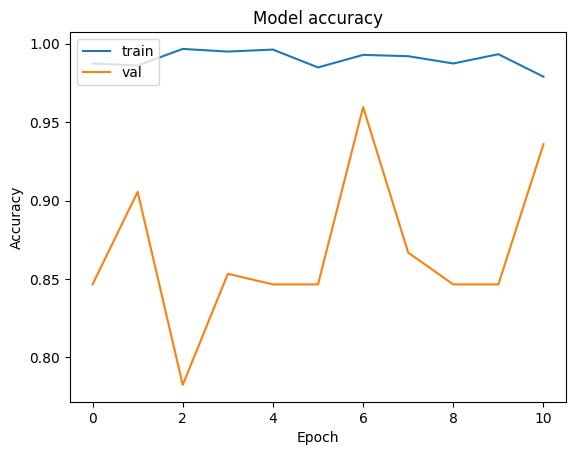

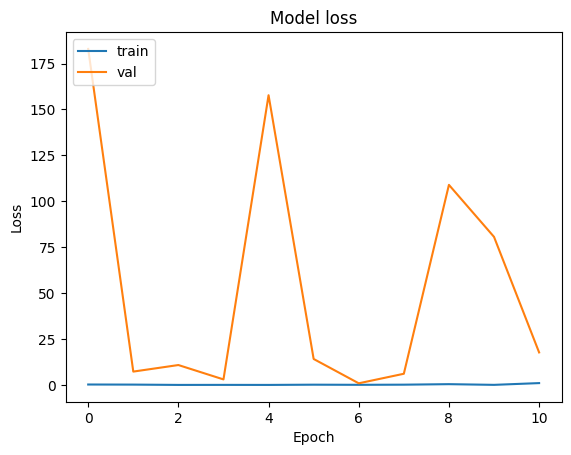

In [51]:

plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

In [1]:
def predict_image(image_path, model):
    if is_image(image_path):
        ela_image = convert_to_ela_image(image_path)
        ela_image_resized = ela_image.resize((img_size, img_size))
        ela_image_array = np.array(ela_image_resized) / 255.0

        anomaly_score, _, _ = detect_anomalies(image_path)
        anomaly_score_normalized = np.full((img_size, img_size, 1), anomaly_score / 10.0)

        combined_features = np.concatenate((ela_image_array, anomaly_score_normalized), axis=2)
        combined_features = np.expand_dims(combined_features, axis=0)

        prediction = model.predict(combined_features)[0]

        return np.argmax(prediction), np.max(prediction)
    elif image_path.lower().endswith('.pdf'):
        pages = convert_from_path(image_path, dpi=300)
        predictions = []
        for page in pages:
            ela_image = page.convert('RGB')
            ela_image_resized = ela_image.resize((img_size, img_size))
            ela_image_array = np.array(ela_image_resized) / 255.0

            anomaly_score, _, _ = detect_anomalies(ela_image_array)
            anomaly_score_normalized = np.full((img_size, img_size, 1), anomaly_score / 10.0)

            combined_features = np.concatenate((ela_image_array, anomaly_score_normalized), axis=2)
            combined_features = np.expand_dims(combined_features, axis=0)

            prediction = model.predict(combined_features)[0]
            predictions.append(prediction)

        avg_prediction = np.mean(predictions, axis=0)
        return np.argmax(avg_prediction), np.max(avg_prediction)
    else:
        raise ValueError("Unsupported file format")

def predict_folder(folder_path, model):
    predictions = []
    for entry in os.listdir(folder_path):
        document_path = os.path.join(folder_path, entry)
        try:
            predicted_class, confidence = predict_image(document_path, model)
            predictions.append((entry, predicted_class, confidence))
            print(f"{entry}: Predicted class {predicted_class} with confidence {confidence:.2f}")
        except Exception as e:
            print(f"Error processing {document_path}: {str(e)}")

    return predictions


In [ ]:
from tensorflow.keras.models import load_model
import os
folder_path = 'images\predict\.ipynb_checkpoints'
model_path = 'anomaly_detection_model.h5'

# Load the model
model = load_model(model_path)

# Predict all documents in the folder   
predictions = predict_folder(folder_path, model)

# Print predictions
for entry, predicted_class, confidence in predictions:
    print(f"{entry}: Predicted class {predicted_class} with confidence {confidence:.2f}")